 # GOLUB use case

In [1]:
library("binom") 
library("evaluomeR")
library("cancerclass")
library("dplyr")
library("caret")
library("MLmetrics")
library("ggplot2")
library("ggrepel")
library("reshape2")

options(scipen=10)

Loading required package: SummarizedExperiment
Loading required package: GenomicRanges
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: 'BiocGenerics'

The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs

The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which

In [2]:
packageVersion("evaluomeR")

[1] '1.7.12'

# Table of contents
* [Dataset](#dataset)
    * [Top 100](#top)
* [evaluomeR - optimal $k$ analysis](#evaluomeR)
    * [Stability plotting](#evaluomeR_stab_plot)
    * [Quality plotting](#evaluomeR_qual_plot)
* [PCA](#pca)
* [Sensitivity](#sensitivity)
* [CER](#cer)

# Dataset <a class="anchor" id="dataset"></a>

In [3]:
load("../use_cases/data/leukemia.RData")
golub = as.data.frame(leukemia)
head(golub)

Case,AFFX.HUMRGE.M10098_5_at,AFFX.HUMRGE.M10098_M_at,AFFX.HUMRGE.M10098_3_at,AFFX.M27830_5_at,D13639_at,D83735_at,D83920_at,D87433_at,D88270_at,...,X65965_s_at,X76223_s_at,AF000424_s_at,M21305_at,U57341_at,HG3576.HT3779_f_at,U01317_cds4_at,M15395_at,M34516_at,Class
B1,4.16250,3.98847,3.93090,3.82930,3.67274,2.00000,2.00000,2.0000,3.29336,...,2.83059,2.00000,3.49914,2.91960,2.30750,3.92536,2.07555,2.23553,3.82595,B
T1,2.78888,2.06070,3.18127,3.34537,3.52724,3.04218,3.35545,2.0000,2.29667,...,3.40926,3.96624,3.71533,2.00000,2.69810,3.25479,2.00000,3.19535,3.46195,T
T2,3.75351,3.51481,3.56443,3.52179,2.00000,2.89321,2.31175,2.0000,2.76268,...,2.52763,4.20412,2.85003,3.38364,2.64345,2.00000,2.23553,2.50379,2.00000,T
B2,3.68574,3.36040,3.40976,3.48544,2.00432,2.00000,2.00000,2.0000,3.68851,...,2.43457,2.00000,2.00000,2.79029,2.98632,3.42911,2.59660,2.37658,3.14364,B
B3,3.10857,3.43632,2.49969,3.05308,3.10585,2.00000,2.30750,2.4014,3.52930,...,2.56820,2.00000,2.73640,2.45637,2.22272,3.37014,2.09342,3.03383,3.36399,B
T3,3.61784,3.43823,3.38093,3.59173,2.00000,2.00000,3.18639,2.0000,2.00000,...,2.50651,4.13117,3.25888,2.00000,2.07918,2.00000,2.00000,3.01536,2.00000,T


Three types of classes within the dataset: **B**, **T** and **M**.

In [4]:
unique(golub["Class"])

,Class
1,B
2,T
28,M


*Further information regarding GOLUB in [cancerclass](https://rdrr.io/bioc/cancerclass/man/GOLUB.html) package.*

Here, we prepare the GOLUB dataset for the analysis, in order to do so, we remove non-numeric columns:

In [5]:
golub["Class"] = NULL # leukemia
golub["sample"] = NULL
golub["type"] = NULL
golub["FAB"] = NULL
golub["gender"] = NULL

In [6]:
head(golub)

Case,AFFX.HUMRGE.M10098_5_at,AFFX.HUMRGE.M10098_M_at,AFFX.HUMRGE.M10098_3_at,AFFX.M27830_5_at,D13639_at,D83735_at,D83920_at,D87433_at,D88270_at,...,X00437_s_at,X65965_s_at,X76223_s_at,AF000424_s_at,M21305_at,U57341_at,HG3576.HT3779_f_at,U01317_cds4_at,M15395_at,M34516_at
B1,4.16250,3.98847,3.93090,3.82930,3.67274,2.00000,2.00000,2.0000,3.29336,...,2.18469,2.83059,2.00000,3.49914,2.91960,2.30750,3.92536,2.07555,2.23553,3.82595
T1,2.78888,2.06070,3.18127,3.34537,3.52724,3.04218,3.35545,2.0000,2.29667,...,4.10690,3.40926,3.96624,3.71533,2.00000,2.69810,3.25479,2.00000,3.19535,3.46195
T2,3.75351,3.51481,3.56443,3.52179,2.00000,2.89321,2.31175,2.0000,2.76268,...,2.00000,2.52763,4.20412,2.85003,3.38364,2.64345,2.00000,2.23553,2.50379,2.00000
B2,3.68574,3.36040,3.40976,3.48544,2.00432,2.00000,2.00000,2.0000,3.68851,...,2.00000,2.43457,2.00000,2.00000,2.79029,2.98632,3.42911,2.59660,2.37658,3.14364
B3,3.10857,3.43632,2.49969,3.05308,3.10585,2.00000,2.30750,2.4014,3.52930,...,2.00000,2.56820,2.00000,2.73640,2.45637,2.22272,3.37014,2.09342,3.03383,3.36399
T3,3.61784,3.43823,3.38093,3.59173,2.00000,2.00000,3.18639,2.0000,2.00000,...,4.20412,2.50651,4.13117,3.25888,2.00000,2.07918,2.00000,2.00000,3.01536,2.00000


## Top 100 <a class="anchor" id="top"></a>
We now filter the metrics for including only the top 100 with the greatest variance, as these metrics have the most significant impact on clustering.

In [7]:
variance = sort(sapply(golub[-1], var,na.rm = TRUE), decreasing = TRUE)  # Sorted gene variance
gene_var = as.data.frame(variance)
gene_var["gene"] = rownames(gene_var)
head(gene_var)

,variance,gene
X82240_rna1_at,0.7720814,X82240_rna1_at
M27891_at,0.6621002,M27891_at
M26311_s_at,0.6585567,M26311_s_at
AFFX.HUMRGE.M10098_5_at,0.6396886,AFFX.HUMRGE.M10098_5_at
Y00787_s_at,0.6343951,Y00787_s_at
M84526_at,0.6198290,M84526_at


In [8]:
top_number = 100
top_genes = gene_var[c(1:top_number), ]
head(top_genes)

,variance,gene
X82240_rna1_at,0.7720814,X82240_rna1_at
M27891_at,0.6621002,M27891_at
M26311_s_at,0.6585567,M26311_s_at
AFFX.HUMRGE.M10098_5_at,0.6396886,AFFX.HUMRGE.M10098_5_at
Y00787_s_at,0.6343951,Y00787_s_at
M84526_at,0.6198290,M84526_at


In [9]:
gene_list = as.list(top_genes["gene"])
top_gene_list = unlist(setdiff(gene_list, names(golub)))
# Top 100 metrics (genes)
top_gene_list

[1] "X82240_rna1_at"          "M27891_at"              
  [3] "M26311_s_at"             "AFFX.HUMRGE.M10098_5_at"
  [5] "Y00787_s_at"             "M84526_at"              
  [7] "M19507_at"               "D88270_at"              
  [9] "M63438_s_at"             "M28130_rna1_s_at"       
 [11] "AFFX.HUMRGE.M10098_M_at" "M12886_at"              
 [13] "M91036_rna1_at"          "AFFX.HUMRGE.M10098_3_at"
 [15] "AFFX.M27830_5_at"        "X00437_s_at"            
 [17] "M21005_at"               "M87789_s_at"            
 [19] "M58459_at"               "M11722_at"              
 [21] "U01317_cds4_at"          "M21305_at"              
 [23] "M27783_s_at"             "L33930_s_at"            
 [25] "J04164_at"               "J04456_at"              
 [27] "X58529_at"               "U89922_s_at"            
 [29] "M21119_s_at"             "M25079_s_at"            
 [31] "M89957_at"               "Z83821_cds2_at"         
 [33] "M57710_at"               "M38690_at"              
 [35] "M57466_s_at"             "X05908_at"              
 [37] "X77737_at"               "M34516_at"              
 [39] "M91438_at"               "M96326_rna1_at"         
 [41] "U05259_rna1_at"          "X76223_s_at"            
 [43] "K01911_at"               "D88422_at"              
 [45] "U05255_s_at"             "X04500_at"              
 [47] "HG3576.HT3779_f_at"      "X95735_at"              
 [49] "X64072_s_at"             "D83735_at"              
 [51] "D83920_at"               "M21904_at"              
 [53] "J03909_at"               "AF000424_s_at"          
 [55] "Z23090_at"               "D13639_at"              
 [57] "J04102_at"               "U57341_at"              
 [59] "M15395_at"               "Z84721_cds2_at"         
 [61] "M38591_at"               "D87433_at"              
 [63] "U46499_at"               "X17042_at"              
 [65] "M63573_at"               "U09770_at"              
 [67] "U20734_s_at"             "M94345_at"              
 [69] "M23178_s_at"             "M11717_rna1_at"         
 [71] "M57731_s_at"             "J03077_s_at"            
 [73] "HG987.HT987_at"          "U02687_at"              
 [75] "L08895_at"               "M12759_at"              
 [77] "M34996_s_at"             "M13560_s_at"            
 [79] "M74719_at"               "X59871_at"              
 [81] "M92934_at"               "U23852_s_at"            
 [83] "U50743_at"               "U60644_at"              
 [85] "U10485_at"               "Z22548_at"              
 [87] "L20971_at"               "M33882_at"              
 [89] "J04615_at"               "X62744_at"              
 [91] "Z69881_at"               "M16279_at"              
 [93] "M21624_at"               "U02020_at"              
 [95] "M16336_s_at"             "L19686_rna1_at"         
 [97] "X65965_s_at"             "X03934_at"              
 [99] "M28826_at"               "M30703_s_at"

In [10]:
top_golub = golub[, top_gene_list]
top_golub["labels"] = rownames(top_golub)
top_golub = top_golub[ , c("labels", names(top_golub)[names(top_golub) != "labels"])] 

The dataframe `top_golub` contains 100 genes (metrics) which provides the most variance.

In [11]:
head(top_golub)

labels,X82240_rna1_at,M27891_at,M26311_s_at,AFFX.HUMRGE.M10098_5_at,Y00787_s_at,M84526_at,M19507_at,D88270_at,M63438_s_at,...,Z69881_at,M16279_at,M21624_at,U02020_at,M16336_s_at,L19686_rna1_at,X65965_s_at,X03934_at,M28826_at,M30703_s_at
1,4.16170,2.48144,2.00000,4.16250,2.52244,2.0000,2.0000,3.29336,3.75143,...,3.24699,3.48841,2.43457,2.24551,2.00000,2.89487,2.83059,2.79449,2.00000,2
2,2.00000,3.13290,3.64856,2.78888,3.72795,2.0000,2.0000,2.29667,3.68646,...,3.30428,4.01932,4.07185,3.05690,3.31513,3.86094,3.40926,3.88434,2.00000,2
3,2.00000,2.40483,2.88930,3.75351,2.47857,2.0000,2.0000,2.76268,2.00000,...,3.55096,3.97211,2.26007,2.06070,3.56384,3.79616,2.52763,4.05312,3.94379,2
4,3.71659,2.00000,2.19590,3.68574,2.38202,2.0000,2.0000,3.68851,2.00000,...,2.91803,3.17406,2.00000,2.00000,2.00000,2.79449,2.43457,2.67578,2.00000,2
5,3.77772,2.00000,3.33746,3.10857,2.00000,2.4624,2.9722,3.52930,2.83696,...,3.17493,3.67596,2.00000,2.33646,2.00000,3.78810,2.56820,2.53782,2.00000,2
6,2.00000,3.06744,3.20737,3.61784,2.33244,2.0000,2.0000,2.00000,2.00000,...,3.41597,3.94655,2.00000,2.00000,3.50947,3.55425,2.50651,3.85485,3.69522,2


# evaluomeR - optimal $k$ analysis <a class="anchor" id="evaluomeR"></a>

In this Section, evaluomeR executes an optimal $k$ analysis. First, stabilities and qualities are calculated, considering all the metrics in the dataset. The $k$ range is $k \in [3,10]$ and the clustering method is `rskc`.

In [12]:
seed = 13606
k.range=c(3,10)
optimal_k = 3 # From Clara optimal k execution
cbi = "rskc"
top_golub = golub
colnames(top_golub)[colnames(top_golub) == 'Case'] <- 'Description'

Automatic computation of $L_1$ bound and $alpha$ accordingot the optimal $k$. The optimal $k$ is retrieved from the `kmeans` analysis in the notebook [golub.ipynb](https://github.com/neobernad/evaluomeR/blob/master/notebooks/use_cases/golub.ipynb). 

In [13]:
L1 =getRSKCL1Boundry(top_golub, k=optimal_k, seed=seed)
alpha = getRSKCAlpha(top_golub, k=optimal_k, L1=L1, seed)

Computing best L1 boundry with 'sparcl::KMeansSparseCluster.permute'
Best L1 found is: 7.24137931034483, using floor: 7
Running stability and quality indexes with alpha=0

Data loaded.
Number of rows: 72
Number of columns: 101


Processing all metrics, 'merge', in dataframe (100)
	Calculation of k = 3

Data loaded.
Number of rows: 72
Number of columns: 101


Processing all metrics, 'merge', in dataframe (100)
	Calculation of k = 3
Running stability and quality indexes with alpha=0.05

Data loaded.
Number of rows: 72
Number of columns: 101


Processing all metrics, 'merge', in dataframe (100)
	Calculation of k = 3

Data loaded.
Number of rows: 72
Number of columns: 101


Processing all metrics, 'merge', in dataframe (100)
	Calculation of k = 3
Running stability and quality indexes with alpha=0.1

Data loaded.
Number of rows: 72
Number of columns: 101


Processing all metrics, 'merge', in dataframe (100)
	Calculation of k = 3

Data loaded.
Number of rows: 72
Number of columns: 101


Proc

# Gold standard classification

In [14]:
dataset_classes = as.vector(as.data.frame(leukemia)["Class"])
level_mapping <- c("T" = 1, "M" = 2, "B" = 3)
map_strings_to_numbers <- function(strings) {
  factorized <- factor(strings, levels = names(level_mapping))
  as.numeric(factorized)
}
# Map categories with cluster number
gold_standard_classification = lapply(dataset_classes, map_strings_to_numbers)
gold_standard_classification = as.vector(unlist(gold_standard_classification))
gold_standard_classification

[1] 3 1 1 3 3 1 3 3 1 1 1 3 3 1 3 3 3 3 3 3 3 3 1 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2
[39] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2

Stability calculation with $k \in [3,10]$ and `clara`:

In [29]:
stab_range = stabilityRange(data=top_golub, k.range=k.range, 
                            bs=100, seed=seed,
                            all_metrics=TRUE,
                            cbi=cbi, L1=L1, alpha=alpha,
                           gold_standard=gold_standard_classification)
stab = standardizeStabilityData(stab_range)
stab


Data loaded.
Number of rows: 72
Number of columns: 102


Processing all metrics, 'merge', in dataframe (101)
	Calculation of k = 3
Gold standard
311331331113313333333313333222222222223333333333333333133322222222222222
Partitions
122112112221121121111121111333333333231111111111112111211133333333332333
Rand Index: 
0.938184663536776
	Calculation of k = 4
Gold standard
311331331113313333333313333222222222223333333333333333133322222222222222
Partitions
234224224442232232222242222131113111312222222222223222322211111111113111
Rand Index: 
0.921752738654147
	Calculation of k = 5
Gold standard
311331331113313333333313333222222222223333333333333333133322222222222222
Partitions
543523553335245245222532525141114111412222252222254222422211111111114111
Rand Index: 
0.809076682316119
	Calculation of k = 6
Gold standard
311331331113313333333313333222222222223333333333333333133322222222222222
Partitions
416226246662414412442262242535551555154222442444441424124435553333551533
Rand Index: 
0.7617370892

 [1] 3 1 1 3 3 1 3 3 1 1 1 3 3 1 3 3 3 3 3 3 3 3 1 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2
[39] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2


In [16]:
stab_range
assay(stab_range$stability_mean)

ExperimentList class object of length 9: 
 [1] stability_mean: SummarizedExperiment with 1 rows and 9 columns 
 [2] cluster_partition: SummarizedExperiment with 1 rows and 9 columns 
 [3] cluster_mean: SummarizedExperiment with 1 rows and 9 columns 
 [4] cluster_centers: SummarizedExperiment with 1 rows and 9 columns 
 [5] cluster_size: SummarizedExperiment with 1 rows and 9 columns 
 [6] cluster_betweenss: SummarizedExperiment with 1 rows and 9 columns 
 [7] cluster_totss: SummarizedExperiment with 1 rows and 9 columns 
 [8] cluster_tot.withinss: SummarizedExperiment with 1 rows and 9 columns 
 [9] cluster_anova: SummarizedExperiment with 1 rows and 9 columns 

Metric,Mean_stability_k_3,Mean_stability_k_4,Mean_stability_k_5,Mean_stability_k_6,Mean_stability_k_7,Mean_stability_k_8,Mean_stability_k_9,Mean_stability_k_10
all_metrics,0.938184663536776,0.863849765258216,0.820031298904538,0.76056338028169,0.714788732394366,0.737480438184664,0.688184663536776,0.692879499217527


## Stability plotting <a class="anchor" id="evaluomeR_stab_plot"></a>

Stability plot

In [17]:
rownames(stab) = c("stab_rskc")
stab$Metric = rownames(stab)
stab$Method = "rskc"
stab_melt = melt(stab, id.vars = c("Metric", "Method"))

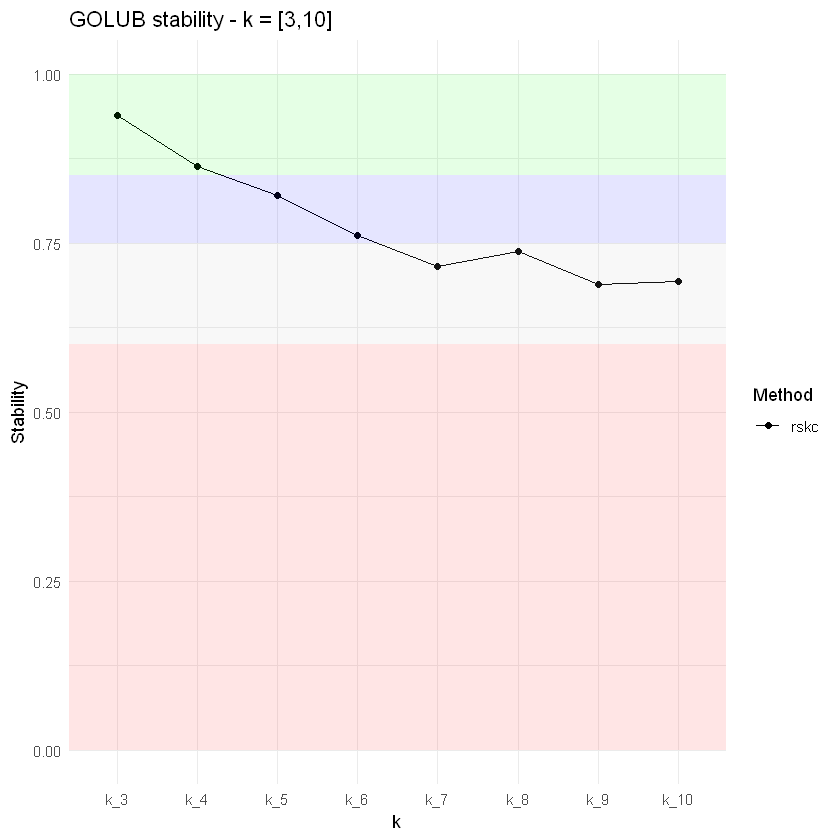

In [18]:
# Color
grayscale_colors <- c("black", "darkgray", "gray", "lightgray", "white")

# Base ggplot
p <- ggplot(stab_melt, aes(x = variable, y = value, color = Method, group = Method)) +
  geom_point() +
  geom_line() +
  scale_color_manual(values = grayscale_colors) +
  labs(
    title = paste0('GOLUB stability - k = [', k.range[1], ",", k.range[2], ']'),
    x = 'k',
    y = 'Stability'
  ) +
  scale_y_continuous(limits = c(0, 1)) +
  theme_minimal()

# Adding rectangles
p + 
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.85, ymax = 1, alpha = 0.1, fill = "green") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.75, ymax = 0.85, alpha = 0.1, fill = "blue") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.6, ymax = 0.75, alpha = 0.1, fill = "gray") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0, ymax = 0.6, alpha = 0.1, fill = "red")



Quality calculation with $k \in [3,10]$ and `RSKC`.

In [19]:
qual_range = qualityRange(data=top_golub, k.range=k.range, 
                            all_metrics=TRUE, seed=seed,
                            cbi=cbi, alpha=alpha, L1=L1)
qual = standardizeQualityData(qual_range)


Data loaded.
Number of rows: 72
Number of columns: 101


Processing all metrics, 'merge', in dataframe (100)
	Calculation of k = 3
	Calculation of k = 4
	Calculation of k = 5
	Calculation of k = 6
	Calculation of k = 7
	Calculation of k = 8
	Calculation of k = 9
	Calculation of k = 10


## Quality plotting <a class="anchor" id="evaluomeR_qual_plot"></a>

Quality plot

In [20]:
rownames(qual) = c("qual_rskc")
qual$Metric = rownames(qual)
qual$Method = cbi
qual_melt = melt(qual, id.vars = c("Metric", "Method"))

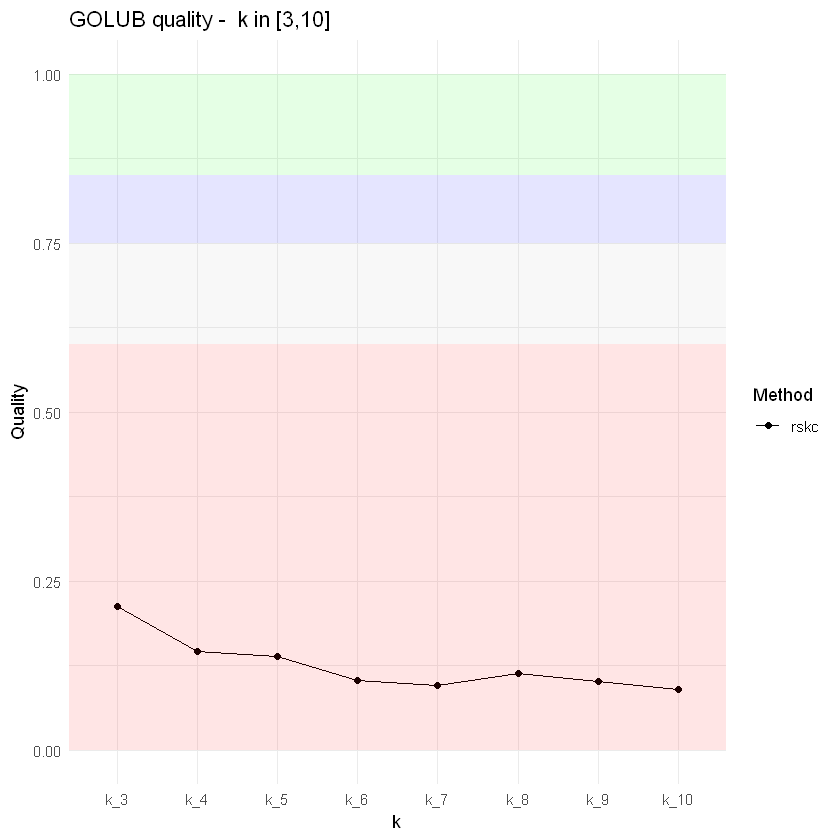

In [21]:
# Color
grayscale_colors <- c("black", "darkgray", "gray", "lightgray", "white")

# Base ggplot
p <- ggplot(qual_melt, aes(x = variable, y = value, color = Method, group = Method)) +
  geom_point() +
  geom_line() +
  scale_color_manual(values = grayscale_colors) +
  labs(
    title = paste0('GOLUB quality -  k in [', k.range[1], ",", k.range[2], ']'),
    x = 'k',
    y = 'Quality'
  ) +
  scale_y_continuous(limits = c(0, 1)) +
  theme_minimal()

# Adding rectangles
p + 
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.85, ymax = 1, alpha = 0.1, fill = "green") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.75, ymax = 0.85, alpha = 0.1, fill = "blue") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.6, ymax = 0.75, alpha = 0.1, fill = "gray") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0, ymax = 0.6, alpha = 0.1, fill = "red")

Determining the optimal $k$ given the stabilities and qualities in `stab_range` and `qual_range` objects:

In [22]:
k_opt = getOptimalKValue(stab_range, qual_range, k.range= k.range)
optimal_k = k_opt$Global_optimal_k
optimal_k_str = paste0("k_", optimal_k)
print(paste0("Optimal k: ", optimal_k))

Processing metric: all_metrics

	Maximum stability and quality values matches the same K value: '3'



[1] "Optimal k: 3"


In [23]:
print(paste0("Stabilities and qualities per k with '", cbi, "' as clustering method"))
stab
qual
print(paste0("Stabily in k=", optimal_k,": ", stab[optimal_k_str]))
print(paste0("Quality in k=", optimal_k,": ", qual[optimal_k_str]))

[1] "Stabilities and qualities per k with 'rskc' as clustering method"


,k_3,k_4,k_5,k_6,k_7,k_8,k_9,k_10,Metric,Method
stab_rskc,0.9381847,0.8638498,0.8200313,0.7605634,0.7147887,0.7374804,0.6881847,0.6928795,stab_rskc,rskc


,k_3,k_4,k_5,k_6,k_7,k_8,k_9,k_10,Metric,Method
qual_rskc,0.2120025,0.1461911,0.1380921,0.1032455,0.09631843,0.1133916,0.1020238,0.09056753,qual_rskc,rskc


[1] "Stabily in k=3: 0.938184663536776"
[1] "Quality in k=3: 0.212002512211207"


# Clusters

In [24]:
# Internal method used to group individuals per cluster
individuals_per_cluster = function(qualityResult) {
    
  qual_df = as.data.frame(assay(qualityResult))
    

  cluster_pos_str = as.character(unlist(qual_df["Cluster_position"]))
  cluster_labels_str = as.character(unlist(qual_df["Cluster_labels"]))

  cluster_pos = as.list(strsplit(cluster_pos_str, ",")[[1]])
  cluster_labels = as.list(strsplit(cluster_labels_str, ",")[[1]])

  individuals_in_cluster = as.data.frame(cbind(cluster_labels, cluster_pos))
  colnames(individuals_in_cluster) = c("Individual", "InCluster")

  return(individuals_in_cluster)
}

In [25]:
cluster_individuals = individuals_per_cluster(assay(qual_range[optimal_k_str]))
print(paste0("CBI: ", cbi, " - k: ", optimal_k))
for (cluster_i in 1:optimal_k) {
    ind_in_cluster = paste(unlist(cluster_individuals[cluster_individuals$InCluster == cluster_i, ]["Individual"]), collapse = ",")
    print(paste("Cluster", cluster_i, ":", ind_in_cluster))
    print("")
}

[1] "CBI: rskc - k: 3"
[1] "Cluster 1 : T1,T2,T3,T4,T5,T6,T7,B10,T8,AML10,B32,T9,AML22"
[1] ""
[1] "Cluster 2 : AML1,AML2,AML3,AML4,AML5,AML6,AML7,AML8,AML9,AML11,AML12,AML13,AML14,AML15,AML16,AML17,AML18,AML19,AML20,AML21,AML23,AML24,AML25"
[1] ""
[1] "Cluster 3 : B1,B2,B3,B4,B5,B6,B7,B8,B9,B11,B12,B13,B14,B15,B16,B17,B18,B19,B20,B21,B22,B23,B24,B25,B26,B27,B28,B29,B30,B31,B33,B34,B35,B36,B37,B38"
[1] ""


# PCA <a class="anchor" id="pca"></a>
We employ Principal Component Analysis (PCA) as a dimensionality reduction technique to facilitate the visualization of clusters within our dataset. PCA allow us to transform the original high-dimensional data into a lower-dimensional space, while preserving as much of the variability as possible.

In [26]:
top_golub["inCluster"] = as.numeric(cluster_individuals$InCluster)
pca_matrix = top_golub %>% select(-Description, -inCluster)
pca_result <- prcomp(pca_matrix, scale. = TRUE)
pca_df <- data.frame(pca_result$x)
pca_df$Cluster <- as.factor(top_golub$inCluster)
pca_df$Individual <- top_golub$Description
head(pca_df)

PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC65,PC66,PC67,PC68,PC69,PC70,PC71,PC72,Cluster,Individual
-5.6600497,-0.9403696,0.6000786,-1.1199127,2.6200577,-4.0006269,0.6478649,-1.5370026,0.8663557,-2.17861488,...,-0.07198869,-0.10318543,-0.1122364,-0.122831348,-0.09263967,0.12561612,0.14561114,1.609823e-15,3,B1
2.6145853,5.2911219,-3.4964281,-6.1124251,1.5135496,-2.1009037,-0.1792254,1.3688467,0.7232899,-0.03349621,...,-0.16755027,0.10902101,0.1899106,0.004990702,-0.14932991,-0.03649268,0.01170500,1.998401e-15,1,T1
-2.1354183,11.4500703,-1.7966203,0.2247835,-0.2318787,1.4493604,0.6051338,-1.4108101,1.4127356,-0.69496786,...,0.17767414,-0.12685695,0.1752885,-0.102442206,0.07161699,-0.05849892,-0.04429441,7.771561e-16,1,T2
-4.9435629,-0.8109685,2.7399280,3.5519694,2.9668022,2.2383532,1.6639109,1.3761154,-0.1218088,1.29753519,...,0.01588035,-0.18295107,0.1511074,0.197330690,-0.01898182,0.02336472,-0.19335383,7.216450e-16,3,B2
-1.1240684,-1.5104914,3.8906659,-0.8401832,1.7507364,2.6570295,2.4860771,-0.1088313,-0.5550100,-1.10456455,...,-0.27438116,-0.09281758,0.1820926,0.225872452,0.06440574,-0.19662224,0.11929858,1.665335e-15,3,B3
-0.9140257,10.9820116,-1.1194102,-0.2948204,-0.1110053,0.8184759,1.6933997,-1.3191906,0.9914184,0.76006577,...,0.17655650,0.05443685,-0.1479246,0.151052951,0.23717942,0.06982347,0.30425593,4.440892e-16,1,T3


Warning message:
"The following aesthetics were dropped during statistical transformation: label.
i This can happen when ggplot fails to infer the correct grouping structure in
  the data.
i Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?"Warning message:
"ggrepel: 1 unlabeled data points (too many overlaps). Consider increasing max.overlaps"

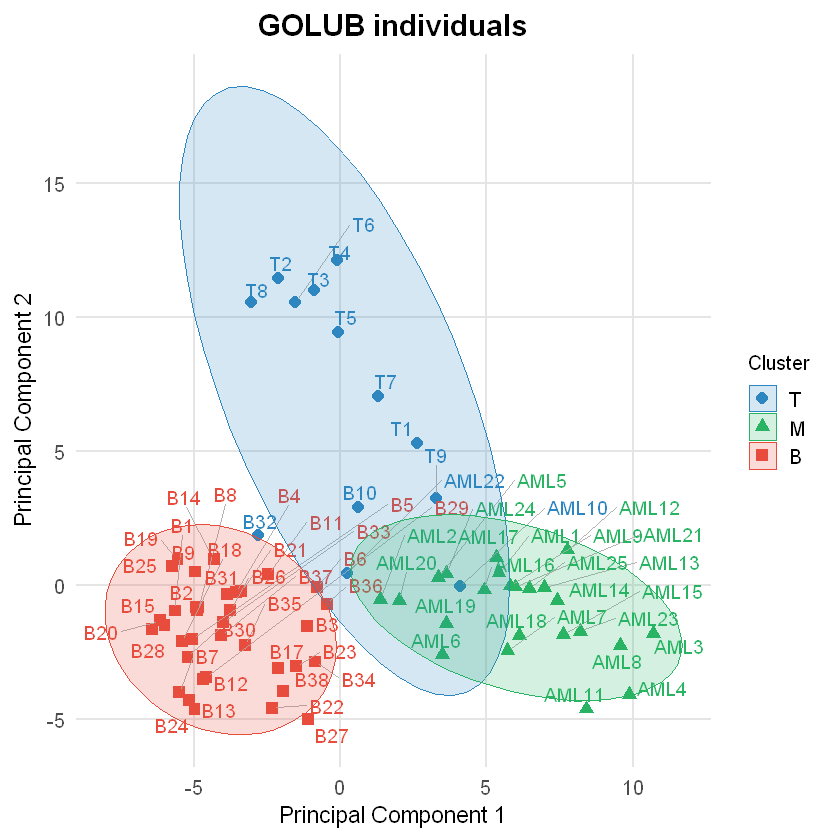

In [27]:
custom_colors <- c("#2E86C1", "#28B463", "#E74C3C", "#9B59B6", "#F1C40F", "#7F8C8D")

cluster_shapes <- c(16, 17, 15, 18, 19)
cluster_labels = names(level_mapping)


ggplot(pca_df, aes(x = PC1, y = PC2, shape = Cluster, color = Cluster, label = Individual)) +
  geom_point(size = 3) +
  geom_text_repel(
    vjust = 1,
    hjust = 1,
    size = 4,
    show.legend = FALSE,
    point.padding = 0.25,
    box.padding = 0.25,
    max.overlaps = 15,
    segment.color = "grey70",
    segment.size = 0.2
  ) +
  stat_ellipse(aes(fill = Cluster), level = 0.95, alpha = 0.2, geom = "polygon") +
  labs(
    title = "GOLUB individuals",
    x = "Principal Component 1",
    y = "Principal Component 2"
  ) +
  scale_shape_manual(values = cluster_shapes, labels = cluster_labels) +
  scale_color_manual(values = custom_colors, labels = cluster_labels) +
  scale_fill_manual(values = custom_colors, labels = cluster_labels) +
  theme_minimal(base_size = 15) +
  theme(
    plot.title = element_text(hjust = 0.5, size = 18, face = "bold"),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    axis.text = element_text(size = 12),
    legend.position = "right",
    legend.title = element_text(size = 12),
    legend.text = element_text(size = 12),
    panel.grid.major = element_line(color = "grey90"),
    panel.grid.minor = element_blank()
  )


# Sensitivity <a class="anchor" id="sensitivity"></a>

In [28]:
# TODO: De aquí no sé si hay que mover algo
# Getting a vector of prediction vs actual classification
actual = as.factor(as.vector(unlist(top_golub["Class_n"])))
predicted <- factor(as.vector(unlist(top_golub["inCluster"])))

print("actual")
actual
print("predicted")
predicted

ERROR: Error in `[.data.frame`(top_golub, "Class_n"): undefined columns selected


In [ ]:
sens <- MLmetrics::Sensitivity(y_pred = predicted, y_true = actual)
sens = format(round(sens*100, 2), nsmall = 2)
print(paste0("Sensitivity: ", sens, "%"))

# CER <a class="anchor" id="cer"></a>
To assess the overall accuracy of our clustering, we compute the Classification Error Rate (CER) and compare it with the gold standard classification. CER represents the proportion of misclassified instances, thus providing a clear measure of the clustering performance in assigning individuals to the correct clusters.

In [ ]:
cer <- CER(predicted, actual)
cer = format(round(cer*100, 2), nsmall = 2)
print(paste0("CER: ", cer, "%"))